In [1]:
# <VSCode-Cell id="part1_initial_setup_and_load" language="python">
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# ----------------------------------------------------------------
# 0. 로컬 환경 설정 안내 (스크립트 실행 전 터미널에서 수행)
# ----------------------------------------------------------------
# 1. Python 3.8 이상 설치되어 있는지 확인
# 2. 필요한 라이브러리 설치 (터미널/명령 프롬프트에서 실행):
#    pip install python-dotenv google-cloud-vision Pillow matplotlib torch torchvision torchaudio transformers accelerate bitsandbytes sentencepiece opencv-python-headless
# 3. NVIDIA GPU 사용 시 (권장):
#    - NVIDIA 드라이버 최신 버전 설치
#    - CUDA Toolkit 설치 (PyTorch와 호환되는 버전)
#    - cuDNN 설치 (PyTorch와 호환되는 버전)
#    - PyTorch GPU 버전 설치 (예: CUDA 11.8 사용 시, PyTorch 공식 웹사이트에서 맞는 명령어 확인)
#      pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#    CPU만 사용 시에는 일반 PyTorch 설치로도 동작하나, Gemma 모델 속도가 매우 느립니다.
# ----------------------------------------------------------------

import os
import sys # sys 임포트 추가 (transformers 설치 시 사용될 수 있음)
import io
import json
import re

# ----------------------------------------------------------------
# 0.1. 캐시 디렉토리 설정
# ----------------------------------------------------------------
# 사용자 환경에 맞게 huggingface_cache 경로를 설정하세요.
new_cache_dir_base = r"D:\김가람의 공부\십라\huggingface_cache" # 사용자가 제공한 경로
hub_cache_dir = os.path.join(new_cache_dir_base, "hub")
os.makedirs(hub_cache_dir, exist_ok=True)
os.environ['HF_HOME'] = new_cache_dir_base
os.environ['HUGGINGFACE_HUB_CACHE'] = hub_cache_dir
os.environ['TRANSFORMERS_CACHE'] = hub_cache_dir
print(f"Hugging Face Cache dir set to: {hub_cache_dir}")

# ----------------------------------------------------------------
# 0.2. .env 파일 로드 및 Google Cloud 인증 설정
# ----------------------------------------------------------------
from dotenv import load_dotenv


env_file_name = "garakey.env"  # 사용자의 .env 파일 이름
current_working_directory = os.getcwd()
env_file_path = os.path.join(current_working_directory, env_file_name)

if os.path.exists(env_file_path):
    load_dotenv(env_file_path, override=True)  # 기존 환경 변수를 덮어쓰도록 설정
    print(f"'{env_file_path}' 파일에서 환경 변수를 로드했습니다.")
else:
    print(f"경고: '{env_file_path}' 파일을 찾을 수 없습니다. 환경 변수 로드에 실패했습니다.")
    print(f"  현재 작업 디렉토리: {current_working_directory}")
    print(f"  찾으려는 .env 파일 경로: {env_file_path}")

# Google Cloud 인증 파일 경로 확인 (환경 변수에서)
# 이 부분은 Vision API 클라이언트 초기화 시 자동으로 사용됩니다.
# 명시적으로 credentials_file 변수를 설정하는 대신 환경 변수를 사용합니다.
credentials_path_from_env = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
if credentials_path_from_env and os.path.exists(credentials_path_from_env):
    print(f"Google Cloud 인증 파일 (환경 변수 GOOGLE_APPLICATION_CREDENTIALS 확인): {credentials_path_from_env}")
else:
    print(f"경고: GOOGLE_APPLICATION_CREDENTIALS 환경 변수가 설정되지 않았거나 해당 파일 경로가 유효하지 않습니다.")
    print(f"  '{env_file_name}' 파일 내의 GOOGLE_APPLICATION_CREDENTIALS 설정을 확인하세요.")
    print(f"  설정된 경로 (없을 수 있음): {credentials_path_from_env}")

# ----------------------------------------------------------------
# 0.3. Gemma 모델 ID 설정 (필요시 다른 곳으로 이동 가능)
# ----------------------------------------------------------------
import torch # torch 임포트는 PyTorch/GPU 확인 또는 모델 로딩 전에 필요
gemma_model_id = "google/gemma-3-4b-it"
print(f"기본 Gemma model ID set to: {gemma_model_id}") # 나중에 경로 설정 셀에서 덮어쓸 수 있음

# ----------------------------------------------------------------
# 1. 라이브러리 임포트
# ----------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import matplotlib.patches as patches
import cv2  # opencv-python-headless
from PIL import Image

# Google Cloud Vision API 클라이언트 임포트
from google.cloud import vision
# from google.cloud.vision_v1 import types # 필요시 명시적으로 사용
# from google.oauth2 import service_account # .env와 환경변수 사용 시 명시적 로드는 불필요

# Transformers 관련 임포트
try:
    from transformers import AutoTokenizer, AutoModelForCausalLM, Gemma3ForConditionalGeneration
    # AutoProcessor는 Gemma2 용
except ImportError:
    print("Transformers 라이브러리 임포트 실패. 설치되어 있는지 확인하세요.")
    print("터미널에서 다음 명령으로 설치할 수 있습니다:")
    print("pip install transformers accelerate bitsandbytes sentencepiece")
    # Jupyter Notebook 환경에서는 아래와 같이 설치 시도 가능 
    # import sys
    # if 'google.colab' in sys.modules or 'ipykernel' in sys.modules:
    #     try:
    #         print("노트북 환경에서 Transformers 설치 시도...")
    #         get_ipython().run_line_magic('pip', 'install --upgrade "transformers>=4.40.0" accelerate bitsandbytes sentencepiece')
    #         from transformers import AutoTokenizer, AutoModelForCausalLM, Gemma3ForConditionalGeneration
    #         print("Transformers 설치 및 임포트 성공.")
    #     except Exception as e_install:
    #         print(f"노트북 내 Transformers 설치 중 오류: {e_install}")
    #         raise
    # else:
    raise # 일반 Python 환경에서는 직접 설치 필요

# --- Matplotlib 한글 폰트 설정 (Windows 기준) ---
font_names_to_try = ['Malgun Gothic', 'NanumGothic', 'AppleGothic', '맑은 고딕', '나눔고딕']
font_found = False
for font_name in font_names_to_try:
    try:
        font_path_check = fm.findfont(font_name, fallback_to_default=False) # 폰트 경로 확인
        if font_path_check: # 경로가 존재하면
            plt.rcParams['font.family'] = font_name # 해당 폰트 이름으로 설정
            print(f"Matplotlib 한글 폰트 설정됨: '{font_name}' (경로: {font_path_check})")
            font_found = True
            break
    except Exception: # findfont가 못찾거나 rcParams 설정 시 오류
        pass # 다음 폰트 시도

if not font_found:
    print("경고: 지정된 한글 폰트('Malgun Gothic', 'NanumGothic' 등)를 시스템에서 찾을 수 없습니다.")
    print("  Matplotlib 시각화 시 한글이 깨질 수 있습니다.")
    print("  시스템에 한글 폰트를 설치하거나, 설치된 폰트 이름을 코드에 추가하여 시도해보세요.")
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

print("\n--- 초기 설정, 환경 변수 로드, 라이브러리 임포트, 폰트 설정 완료 ---")

# ----------------------------------------------------------------
# 2. 주요 설정, 변수 및 경로 정의
# ----------------------------------------------------------------
# !!!! 중요: 아래 base_folder_path와 image_file_name을 실제 환경에 맞게 수정해주세요!!!!
base_folder_path = r"D:\김가람의 공부\십라\-\새 폴더\사진"  # 영수증 이미지가 있는 폴더
image_file_name = "영수증 이미지 1.jpg"  # 실제 영수증 이미지 파일명 (확장자 포함)
image_path = os.path.join(base_folder_path, image_file_name)

# Gemma 모델 ID (위에서 설정한 기본값을 여기서 덮어쓸 수 있음)
# gemma_model_id = "google/gemma-3-4b-it" #

# 출력 파일 이름 설정 (결과 저장 시 사용)
output_json_file_template = "receipt_data_vision_{gemma_model_name}.json"

# --- 경로 및 모델 ID 출력 확인 ---
print(f"\n사용할 이미지 경로: {image_path}")
print(f"사용할 Gemma 모델 ID: {gemma_model_id}") # 여기서 사용될 최종 모델 ID 확인

# --- 이미지 파일 존재 여부 및 로드 가능성 확인 ---
receipt_image_pil = None # 이미지 객체 초기화
if not os.path.exists(image_path):
    print(f"에러: 이미지 파일을 다음 경로에서 찾을 수 없습니다: {image_path}")
    print("  스크립트 실행에 문제가 발생할 수 있습니다. 경로를 확인해주세요.")
    # raise FileNotFoundError(f"이미지 파일을 찾을 수 없습니다: {image_path}") # 필요시 주석 해제하여 중단
else:
    try:
        # 이미지 로드 시도
        receipt_image_pil = Image.open(image_path)
        print(f"이미지 로드 성공: {receipt_image_pil.format}, {receipt_image_pil.size}, {receipt_image_pil.mode}")
    except Exception as e:
        print(f"이미지 파일({image_path}) 로드 중 오류 발생: {e}")
        receipt_image_pil = None # 오류 시 None으로 설정

print("\n--- 주요 설정, 변수, 경로 정의 및 이미지 로드 시도 완료 ---")

# ----------------------------------------------------------------
# PyTorch 및 GPU 확인
# ----------------------------------------------------------------
print(f"\nPyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능 여부: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA 버전 (PyTorch 빌드 시 사용된 버전): {torch.version.cuda if torch.version.cuda else 'N/A'}")
    print(f"사용 가능한 GPU 개수: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA를 사용할 수 없습니다. 모델이 CPU로 실행됩니다 (속도 저하가 예상됩니다).")

print("\n--- 파트 1 (설정 및 이미지 로드) 완료 ---")
# </VSCode-Cell>

Hugging Face Cache dir set to: D:\김가람의 공부\십라\huggingface_cache\hub
'd:\김가람의 공부\십라\-\garakey.env' 파일에서 환경 변수를 로드했습니다.
Google Cloud 인증 파일 (환경 변수 GOOGLE_APPLICATION_CREDENTIALS 확인): D:/김가람의 공부/십라/-/새 폴더/api/chinamoney-42dd61d0050f.json
기본 Gemma model ID set to: google/gemma-3-4b-it


C:\Users\jodoo\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\jodoo\AppData\Roaming\Python\Python310\site-packages\transformers\utils\hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Matplotlib 한글 폰트 설정됨: 'Malgun Gothic' (경로: C:\Windows\Fonts\malgun.ttf)

--- 초기 설정, 환경 변수 로드, 라이브러리 임포트, 폰트 설정 완료 ---

사용할 이미지 경로: D:\김가람의 공부\십라\-\새 폴더\사진\영수증 이미지 1.jpg
사용할 Gemma 모델 ID: google/gemma-3-4b-it
이미지 로드 성공: JPEG, (666, 805), RGB

--- 주요 설정, 변수, 경로 정의 및 이미지 로드 시도 완료 ---

PyTorch 버전: 2.2.2+cu118
CUDA 사용 가능 여부: True
CUDA 버전 (PyTorch 빌드 시 사용된 버전): 11.8
사용 가능한 GPU 개수: 1
  GPU 0: NVIDIA GeForce RTX 4070 SUPER

--- 파트 1 (설정 및 이미지 로드) 완료 ---


In [2]:

print(os.getenv("GOOGLE_APPLICATION_CREDENTIALS"))

D:/김가람의 공부/십라/-/새 폴더/api/chinamoney-42dd61d0050f.json


In [3]:

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU count: {torch.cuda.device_count()}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.2.2+cu118
CUDA available: True
CUDA version: 11.8
GPU count: 1
GPU name: NVIDIA GeForce RTX 4070 SUPER



--- 파트 2 (처리 및 저장) 시작 ---


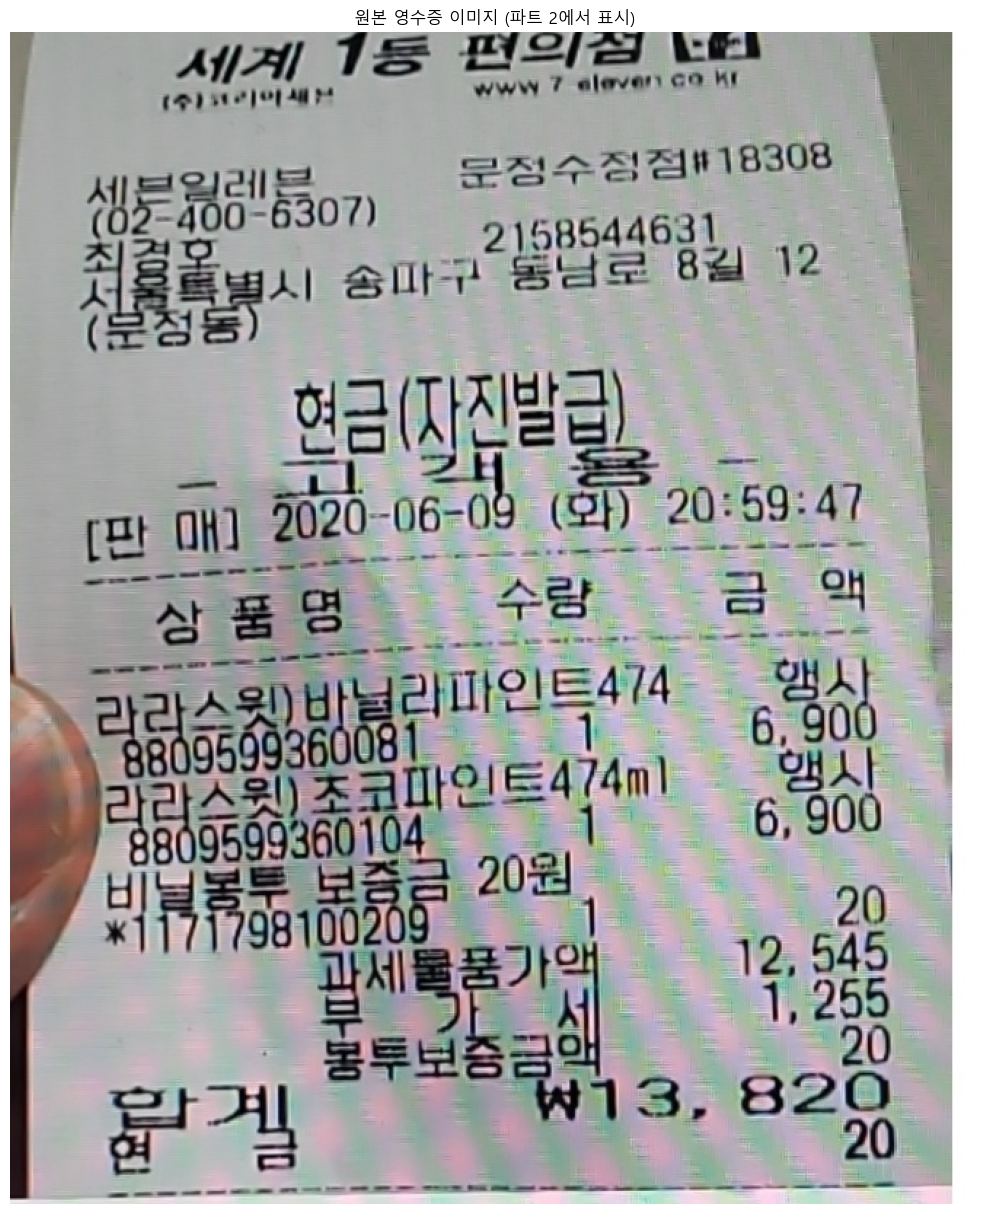

원본 이미지 표시 완료 (파트 2).

=== Google Cloud Vision API 클라이언트 초기화 시도 (파트 2)... ===
Google Cloud Vision API 클라이언트 초기화 성공 (환경 변수 자동 감지, 파트 2).

=== Google Cloud Vision API로 OCR 처리 시작 (파트 2)... ===
Google Cloud Vision API를 사용한 OCR 처리 중 오류 발생 (파트 2): 401 Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project. [reason: "ACCESS_TOKEN_EXPIRED"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "vision.googleapis.com"
}
metadata {
  key: "method"
  value: "google.cloud.vision.v1.ImageAnnotator.BatchAnnotateImages"
}
]
시각화할 충분한 OCR 결과(텍스트 요소)가 없거나 원본 이미지가 없습니다 (파트 2).
OCR 결과가 비어있거나 공백만 있어 Gemma JSON 구조화를 건너뜁니다 (파트 2).
Gemma 모델 또는 토크나이저가 로드되지 않아 JSON 구조화를 건너뜁니다 (파트 2).

Gemma로부터 추출된 유효한 JSON 데이터가 없어 파일이 저장되지 않았습니다 (파트 2).

--- 파트 2 (처리 및 저장) 완료 ---


In [4]:
# <VSCode-Cell id="part2_processing_and_saving" language="python">
# 이 셀을 실행하기 전에 위의 "part1_initial_setup_and_load" 셀이 성공적으로 실행되어야함.
# receipt_image_pil, image_path, gemma_model_id, base_folder_path, output_json_file_template 등의 변수 설정 되었는지 확인

# ----------------------------------------------------------------
# 3. 원본 이미지 표시 (파트 2 시작)
# ----------------------------------------------------------------
print("\n--- 파트 2 (처리 및 저장) 시작 ---")
if receipt_image_pil: # receipt_image_pil 객체가 part1에서 성공적으로 로드되었는지 확인
    try:
        plt.figure(figsize=(10, 15))
        plt.title("원본 영수증 이미지 (파트 2에서 표시)")
        plt.imshow(receipt_image_pil)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        print("원본 이미지 표시 완료 (파트 2).")
    except Exception as e:
        print(f"이미지 표시 중 오류 발생 (파트 2): {e}")
else:
    print("이미지 객체(receipt_image_pil)가 로드되지 않아 원본 이미지를 표시할 수 없습니다 (파트 2).")
    print("파트 1 셀을 먼저 실행하고 이미지 경로를 확인해주세요.")

# ----------------------------------------------------------------
# 4. Google Cloud Vision API를 사용한 OCR 처리
# ----------------------------------------------------------------
vision_client = None
ocr_full_text_for_gemma = ""  # OCR 결과를 저장할 변수 초기화
texts_from_vision_api = None  # Vision API의 text_annotations 전체를 저장할 변수 초기화

print("\n=== Google Cloud Vision API 클라이언트 초기화 시도 (파트 2)... ===")
try:
    # GOOGLE_APPLICATION_CREDENTIALS 환경 변수가 .env 파일을 통해 올바르게 설정되어 있어야 함 (파트 1에서 처리).
    # 파트 1에서 환경 변수가 설정되었으므로, 별도의 credentials 파일 지정 없이 클라이언트 생성 가능.
    vision_client = vision.ImageAnnotatorClient()
    print("Google Cloud Vision API 클라이언트 초기화 성공 (환경 변수 자동 감지, 파트 2).")
except Exception as e:
    print(f"Google Cloud Vision API 클라이언트 초기화 오류 (파트 2): {e}")
    print("  파트 1에서 .env 파일의 GOOGLE_APPLICATION_CREDENTIALS 설정 및 JSON 키 파일 경로를 확인하세요.")
    vision_client = None

if vision_client and image_path and os.path.exists(image_path) and receipt_image_pil:
    print("\n=== Google Cloud Vision API로 OCR 처리 시작 (파트 2)... ===")
    try:
        with io.open(image_path, 'rb') as image_file_for_vision:
            content_for_vision = image_file_for_vision.read()
        
        image_to_process_vision = vision.Image(content=content_for_vision)
        
        response_from_vision = vision_client.text_detection(image=image_to_process_vision)
        texts_from_vision_api = response_from_vision.text_annotations # API 응답의 text_annotations 저장

        if response_from_vision.error.message:
            print(f"Vision API 오류 발생 (파트 2): {response_from_vision.error.message}")
        elif not texts_from_vision_api:
            print("OCR 결과 (파트 2): Vision API에서 텍스트를 감지하지 못했습니다.")
        else:
            print(f"OCR 처리 완료 (파트 2): {len(texts_from_vision_api)} 개의 텍스트 요소(annotations) 감지됨.")
            ocr_full_text_for_gemma = texts_from_vision_api[0].description # 전체 텍스트 추출
            
            print("\n--- Google Cloud Vision API가 인식한 전체 텍스트 (파트 2) ---")
            ocr_lines_for_print = ocr_full_text_for_gemma.split('\n')
            for i, line in enumerate(ocr_lines_for_print[:100]): 
                 print(f"  Line {i+1}: {line}")
            if len(ocr_lines_for_print) > 100:
                print(f"  ... (총 {len(ocr_lines_for_print)} 줄 중 일부만 표시)")
            print("--- ---")

    except Exception as e:
        print(f"Google Cloud Vision API를 사용한 OCR 처리 중 오류 발생 (파트 2): {e}")
        ocr_full_text_for_gemma = "" 
        texts_from_vision_api = None
else:
    if not vision_client:
        print("Google Cloud Vision API 클라이언트가 초기화되지 않아 OCR 처리를 건너뜁니다 (파트 2).")
    if not (image_path and os.path.exists(image_path) and receipt_image_pil) and vision_client: 
        print(f"이미지 파일({image_path})이 없거나 로드되지 않아 OCR 처리를 건너뜁니다 (파트 2).")
        print("  파트 1 셀을 실행하여 이미지 경로 및 로드 상태를 확인하세요.")

# ----------------------------------------------------------------
# 5. OCR 결과 시각화 (Vision API 바운딩 박스)
# ----------------------------------------------------------------
if texts_from_vision_api and len(texts_from_vision_api) > 1 and receipt_image_pil:
    print("\n=== OCR 결과 시각화 중 (파트 2)... ===")
    try:
        plt.figure(figsize=(12, 18)) 
        plt.imshow(receipt_image_pil)
        ax = plt.gca()

        for text_annotation in texts_from_vision_api[1:]: 
            vertices = [(vertex.x, vertex.y) for vertex in text_annotation.bounding_poly.vertices]
            polygon = patches.Polygon(vertices, closed=True, linewidth=1, edgecolor='lime', facecolor='none')
            ax.add_patch(polygon)
            
            display_text = text_annotation.description
            plt.text(vertices[0][0], vertices[0][1] - 5, display_text, 
                     color="magenta", fontsize=6,
                     bbox=dict(facecolor="white", alpha=0.7, pad=0.1, edgecolor='none')) 
        
        plt.title("Google Cloud Vision API OCR 결과 (바운딩 박스, 파트 2)")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        print("OCR 결과 시각화 완료 (파트 2).")
    except Exception as e:
        print(f"OCR 결과 시각화 중 오류 발생 (파트 2): {e}")
elif not receipt_image_pil:
    print("원본 이미지가 로드되지 않아 OCR 결과를 시각화할 수 없습니다 (파트 2).")
else:
    print("시각화할 충분한 OCR 결과(텍스트 요소)가 없거나 원본 이미지가 없습니다 (파트 2).")

# ----------------------------------------------------------------
# 6. Gemma를 이용한 JSON 구조화
# ----------------------------------------------------------------
parsed_json_from_gemma = None 
gemma_model_loaded = None     
gemma_tokenizer_loaded = None 

if ocr_full_text_for_gemma and ocr_full_text_for_gemma.strip():
    print("\n=== Gemma 모델 로딩 및 실행 준비 (파트 2)... ===")
    print(f"사용할 Gemma 모델 ID (파트 1에서 설정됨): '{gemma_model_id}'")
    print(f"'{gemma_model_id}' 모델 로딩 시도 (파트 2)...")
    
    try:
        gemma_tokenizer_loaded = AutoTokenizer.from_pretrained(gemma_model_id)
        
        if torch.cuda.is_available():
            device_for_gemma = "cuda"
            try:
                _ = torch.tensor([1.0], dtype=torch.bfloat16).to(device_for_gemma)
                dtype_for_gemma = torch.bfloat16
                print(f"NVIDIA GPU 감지됨. Gemma를 {device_for_gemma}에서 {dtype_for_gemma}로 로드 시도 (파트 2).")
            except RuntimeError: 
                try:
                    _ = torch.tensor([1.0], dtype=torch.float16).to(device_for_gemma)
                    dtype_for_gemma = torch.float16
                    print(f"NVIDIA GPU 감지됨 (bfloat16 미지원). Gemma를 {device_for_gemma}에서 {dtype_for_gemma}로 로드 시도 (파트 2).")
                except RuntimeError: 
                    dtype_for_gemma = torch.float32
                    print(f"NVIDIA GPU 감지됨 (bfloat16/float16 미지원). Gemma를 {device_for_gemma}에서 {dtype_for_gemma}로 로드 시도 (파트 2).")
        else:
            device_for_gemma = "cpu"
            dtype_for_gemma = torch.float32 
            print(f"NVIDIA GPU를 찾을 수 없습니다. Gemma를 CPU로 로드합니다 (파트 2, 매우 느릴 수 있음).")

        gemma_model_loaded = Gemma3ForConditionalGeneration.from_pretrained(
            gemma_model_id,
            torch_dtype=dtype_for_gemma,
            device_map="auto", 
            load_in_4bit=True, # 필요시 주석 해제 (bitsandbytes 필요)
        )
        print(f"'{gemma_model_id}' 모델 로드 완료. 실행 장치: {gemma_model_loaded.device} (파트 2)")

    except Exception as e:
        print(f"Gemma 모델 로딩 중 오류 (파트 2): {e}")
        gemma_model_loaded = None 
        gemma_tokenizer_loaded = None

    if gemma_model_loaded and gemma_tokenizer_loaded:
        prompt_for_gemma = f"""당신은 제공된 "OCR 결과" 텍스트에서 정보를 추출하여 지정된 JSON 형식으로 정리하는 AI 어시스턴트입니다.
가장 중요한 목표는 영수증의 **최종 결제 총액 (total_price)**을 정확하게 추출하는 것입니다.
다른 모든 정보도 중요하지만, **total_price**는 반드시 포함되어야 합니다.

**정보 추출 지침:**
*   **반드시 "OCR 결과" 텍스트에 있는 실제 데이터를 사용해야 합니다.** 없는 정보는 추측하거나 임의로 만들지 마세요.
*   존재하지 않는 정보는 빈 문자열("") 또는 JSON 형식에 따라 `null` 값으로 표시합니다.
*   숫자 값(가격, 수량 등)은 콤마(,)를 제거하고 숫자 형태의 문자열로 표현해주세요 (예: "48360").
*   날짜 및 시간은 "YYYY-MM-DD HH:MM:SS" 형식을 최우선으로 시도하고, 어려우면 OCR 결과에 인식된 그대로 제공해주세요.
*   상품 목록(items)에서 단가(unit_price), 수량(quantity), 합계(total)는 숫자 형태의 문자열로, 상품명(name)은 문자열로 추출해주세요.
*   수량이 명시되지 않은 경우 기본값으로 "1"을 사용합니다.

**요구되는 JSON 형식 예시:**
```json
{{
  "store_name": "가게 이름 (문자열)",
  "address": "가게 주소 (문자열)",
  "business_number": "사업자 번호 (문자열, 예: 123-45-67890)",
  "phone": "전화번호 (문자열, 예: 010-1234-5678)",
  "date": "거래 날짜 및 시간 (문자열, 예: 2024-08-17 11:31:45)",
  "total_price": "영수증의 최종 결제 총액 (숫자 문자열, 예: 48360)",
  "items": [
    {{
      "name": "상품명1 (문자열)",
      "unit_price": "단가1 (숫자 문자열)",
      "quantity": "수량1 (숫자 문자열, 없으면 1)",
      "total": "상품1 총액 (숫자 문자열)"
    }},
    {{
      "name": "상품명2 (문자열)",
      "unit_price": "단가2 (숫자 문자열)",
      "quantity": "수량2 (숫자 문자열)",
      "total": "상품2 총액 (숫자 문자열)"
    }}
  ]
}}
```

--- OCR 결과 시작 ---
{ocr_full_text_for_gemma}
--- OCR 결과 끝 ---

위 "OCR 결과"를 바탕으로 JSON 객체를 생성해주세요.
응답은 다른 설명 없이 순수한 JSON 객체만 포함해야 합니다.
**특히, `total_price` 필드에는 영수증에 명시된 사용자가 실제로 지불해야 하는 최종 금액을 정확히 기입해야 합니다.**

정리된 JSON:
"""

        print("\n=== Gemma 모델로 JSON 생성 시작 (파트 2)... ===")
        generated_json_text_from_model = ""
        try:
            inputs = gemma_tokenizer_loaded(
                prompt_for_gemma, 
                return_tensors="pt", 
                padding=True, 
                truncation=True, # 입력이 길 경우 잘라냄
            ).to(gemma_model_loaded.device)
            
            # generate 함수 호출 방식 수정: pad_token_id를 명시적으로 전달하지 않고, attention_mask를 사용
            outputs = gemma_model_loaded.generate(
                inputs.input_ids,
                attention_mask=inputs.attention_mask, 
                max_new_tokens=2048,  
                temperature=0.0,      
                do_sample=False,
                # pad_token_id는 여기서 전달하지 않음 (모델 기본값 또는 토크나이저 설정 따름)
            )
            
            # 생성된 텍스트 부분만 추출 (입력 프롬프트 제외)
            # generate 함수가 입력 ID를 포함하여 반환하는 경우, 생성된 부분만 잘라냅니다.
            # Gemma 모델과 transformers 버전에 따라 generate의 기본 동작이 다를 수 있습니다.
            # 일반적으로 input_ids를 전달하면, outputs에는 input_ids 이후의 생성된 토큰들이 포함됩니다.
            # 만약 outputs[0]이 이미 생성된 토큰들만 포함한다면, 아래 슬라이싱은 불필요하거나 오류를 유발할 수 있습니다.
            # 하지만, 안전하게 입력 길이를 기준으로 잘라내는 것이 일반적입니다.
            if inputs.input_ids.shape[-1] < outputs.shape[-1]: # 생성된 토큰이 있을 경우
                 output_tokens_only = outputs[0][inputs.input_ids.shape[-1]:]
            else: # 생성된 토큰이 없는 경우 (예: max_new_tokens=0 또는 오류)
                 output_tokens_only = outputs[0] # 또는 빈 텐서로 처리

            generated_text_from_model_raw = gemma_tokenizer_loaded.decode(output_tokens_only, skip_special_tokens=True)

            print("\n--- Gemma 모델 생성 원본 텍스트 (파트 2) ---")
            print(generated_text_from_model_raw)
            
            json_output_marker = "정리된 JSON:"
            if json_output_marker in generated_text_from_model_raw:
                generated_json_text_from_model = generated_text_from_model_raw.split(json_output_marker, 1)[-1].strip()
            else:
                generated_json_text_from_model = generated_text_from_model_raw.strip()

            # JSON 코드 블록 추출 (```json ... ```)
            match_json_code_block = re.search(r"```json\s*([\s\S]+?)\s*```", generated_json_text_from_model, re.DOTALL)
            if match_json_code_block:
                generated_json_text_from_model = match_json_code_block.group(1).strip()
            else:
                # 코드 블록이 없을 경우, 가장 바깥쪽 중괄호 기준으로 추출 시도
                first_brace = generated_json_text_from_model.find('{')
                last_brace = generated_json_text_from_model.rfind('}')
                if first_brace != -1 and last_brace != -1 and first_brace < last_brace:
                    # 단순 find/rfind로 찾은 중괄호가 실제 JSON 객체의 시작/끝이 아닐 수 있음
                    # 좀 더 정확한 JSON 객체 경계를 찾기 위한 로직 (이전 코드 유지)
                    temp_json_str = generated_json_text_from_model[first_brace : last_brace+1]
                    try:
                        # 임시로 파싱 시도하여 유효한 JSON인지 확인하고, 그 부분을 사용
                        json.loads(temp_json_str)
                        generated_json_text_from_model = temp_json_str
                    except json.JSONDecodeError:
                        # 파싱 실패 시, 이전의 복잡한 중첩 중괄호 로직 사용 또는 다른 방법 고려
                        # 아래는 이전 코드의 중첩 중괄호 로직 일부
                        start_brace_index = generated_json_text_from_model.rfind("{") # 가장 마지막 '{'부터 시작
                        end_brace_index = -1
                        if start_brace_index != -1:
                            open_braces_count = 0
                            for i in range(start_brace_index, len(generated_json_text_from_model)):
                                if generated_json_text_from_model[i] == '{': open_braces_count += 1
                                elif generated_json_text_from_model[i] == '}':
                                    open_braces_count -= 1
                                    if open_braces_count == 0: end_brace_index = i; break
                            if end_brace_index != -1 and start_brace_index < end_brace_index : 
                                generated_json_text_from_model = generated_json_text_from_model[start_brace_index : end_brace_index+1].strip()
                            else:
                                # 위 로직으로도 못 찾으면, 그냥 처음 찾은 중괄호 사용
                                if first_brace != -1 and last_brace != -1 and first_brace < last_brace:
                                     generated_json_text_from_model = generated_json_text_from_model[first_brace:last_brace+1].strip()
                                else:
                                     generated_json_text_from_model = "" # 최후의 경우 빈 문자열
                        else:
                            generated_json_text_from_model = ""
                elif first_brace != -1 and last_brace != -1 and first_brace < last_brace : # 단순 중괄호 쌍
                     generated_json_text_from_model = generated_json_text_from_model[first_brace:last_brace+1].strip()
                else: # 중괄호를 못찾으면 빈 문자열
                    generated_json_text_from_model = ""


            print("\n--- 추출된 JSON 텍스트 (파싱 시도 전, 파트 2) ---")
            print(generated_json_text_from_model)

            if generated_json_text_from_model:
                try:
                    # 최종적으로 JSON 파싱 전, 문자열 앞뒤의 불필요한 공백이나 마크다운 제거
                    # 이미 위에서 ```json ``` 제거 로직이 있지만, 한 번 더 정리
                    cleaned_json_text = generated_json_text_from_model.strip()
                    if cleaned_json_text.startswith("```json"):
                        cleaned_json_text = cleaned_json_text[len("```json"):].strip()
                    if cleaned_json_text.endswith("```"):
                        cleaned_json_text = cleaned_json_text[:-len("```")].strip()
                    
                    # 가장 바깥쪽 중괄호만 남기도록 한번 더 시도 (모델이 불필요한 텍스트를 앞뒤로 붙일 경우 대비)
                    first_brace_final = cleaned_json_text.find('{')
                    last_brace_final = cleaned_json_text.rfind('}')
                    if first_brace_final != -1 and last_brace_final != -1 and first_brace_final < last_brace_final:
                        cleaned_json_text = cleaned_json_text[first_brace_final:last_brace_final+1]
                    
                    parsed_json_from_gemma = json.loads(cleaned_json_text)
                    print("\n--- Gemma 생성 및 파싱된 JSON 객체 (파트 2) ---")
                    print(json.dumps(parsed_json_from_gemma, indent=2, ensure_ascii=False))
                    
                    if "total_price" in parsed_json_from_gemma and parsed_json_from_gemma.get("total_price") is not None:
                        print(f"\n Gemma 추출 최종 결제 금액: {parsed_json_from_gemma['total_price']} (파트 2) 🎯")
                    else:
                        print("\n Gemma 생성 JSON에서 'total_price'를 찾지 못하거나 비어있음 (파트 2).")
                except json.JSONDecodeError as e_json:
                    print(f"\nJSON 파싱 오류 (파트 2): {e_json}")
                    print(f"파싱 시도한 텍스트: '{cleaned_json_text}'")
            else:
                print("\nGemma로부터 유효한 JSON 텍스트를 추출하지 못함 (파트 2).")
        except Exception as e_runtime:
            print(f"Gemma 모델 실행 또는 결과 처리 중 오류 (파트 2): {e_runtime}")
            import traceback
            traceback.print_exc() # 오류 발생 시 스택 트레이스 출력
else:
    if not (ocr_full_text_for_gemma and ocr_full_text_for_gemma.strip()):
        print("OCR 결과가 비어있거나 공백만 있어 Gemma JSON 구조화를 건너뜁니다 (파트 2).")
    if not gemma_model_loaded or not gemma_tokenizer_loaded: 
        print("Gemma 모델 또는 토크나이저가 로드되지 않아 JSON 구조화를 건너뜁니다 (파트 2).")

# ----------------------------------------------------------------
# 7. 결과 파일로 저장
# ----------------------------------------------------------------
if parsed_json_from_gemma: 
    safe_gemma_model_name = gemma_model_id.split('/')[-1].replace('-', '_').replace('.', '_')
    output_json_file = output_json_file_template.format(gemma_model_name=safe_gemma_model_name)
    output_json_path = os.path.join(base_folder_path, output_json_file)

    try:
        with open(output_json_path, 'w', encoding='utf-8') as f_out:
            json.dump(parsed_json_from_gemma, f_out, ensure_ascii=False, indent=2)
        print(f"\n Gemma 추출 데이터 저장 완료 (파트 2):")
        print(f"   {output_json_path}")
    except Exception as e_save:
        print(f"결과 파일 저장 중 오류 (파트 2): {e_save} (경로: {output_json_path})")
else:
    print(f"\nGemma로부터 추출된 유효한 JSON 데이터가 없어 파일이 저장되지 않았습니다 (파트 2).")

print("\n--- 파트 2 (처리 및 저장) 완료 ---")
# </VSCode-Cell>